# 머신 러닝 교과서 3판

# 7장 - 다양한 모델을 결합한 앙상블 학습

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch07/ch07.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch07/ch07.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

### 목차

- 앙상블 학습
- 다수결 투표를 사용한 분류 앙상블
    - 간단한 다수결 투표 분류기 구현
    - 다수결 투표 방식을 사용하여 예측 만들기
    - 앙상블 분류기의 평가와 튜닝
- 배깅: 부트스트랩 샘플링을 통한 분류 앙상블
    - 배깅 알고리즘의 작동 방식
    - 배깅으로 Wine 데이터셋의 샘플 분류
- 약한 학습기를 이용한 에이다부스트
    - 부스팅 작동 원리
    - 사이킷런에서 에이다부스트 사용
- 요약

<br>
<br>

In [1]:
# 코랩에서 실행할 경우 최신 버전의 사이킷런을 설치합니다.
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.2MB 62.0MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
from IPython.display import Image

# 앙상블 학습

In [3]:
Image(url='https://git.io/JtskW', width=500) 

In [4]:
Image(url='https://git.io/Jtskl', width=500) 

In [5]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [6]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

scipy의 `binom.cdf()`를 사용하여 계산할 수도 있습니다. 성공 확률이 75%인 이항 분포에서 11번의 시도 중에 5개 이하로 성공할 누적 확률은 다음과 같이 계산합니다.

In [7]:
from scipy.stats import binom

binom.cdf(5, 11, 0.75)

0.03432750701904298

In [8]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

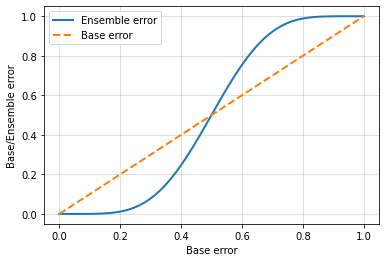

In [9]:
import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
# plt.savefig('images/07_03.png', dpi=300)
plt.show()

<br>
<br>

# 다수결 투표를 사용한 분류 앙상블

## 간단한 다수결 투표 분류기 구현

In [10]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

In [11]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [12]:
np.argmax(p)

0

In [13]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
    
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        -------
        self : 객체
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
        
        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬
        
        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

<br>
<br>

## 다수결 투표 방식을 사용하여 예측 만들기

In [14]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [15]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [16]:
# 다수결 (하드) 투표

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


사이킷런의 `VotingClassifier`를 사용해 보겠습니다. `estimators` 매개변수에는 분류기 이름과 객체로 구성된 튜플의 리스트를 입력합니다. 앞에서 만든 `MajorityVoteClassifier`는 `vote` 매개변수에 상관없이 `predict_proba` 메서드를 실행할 수 있지만 사이킷런의 `VotingClassifier`는 `voting='hard'`일 경우 `predict_proba` 메서드를 지원하지 않습니다. ROC AUC를 계산하기 위해서는 예측 확률이 필요하므로 `voting='soft'`로 지정합니다.

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train, 
                        cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(), 
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.98 (+/- 0.05) [VotingClassifier]


`VotingClassifier`의 `fit` 메서드를 호출할 때 진행 과정을 출력하려면 0.23버전에서 추가된 `verbose` 매개변수를 `True`로 지정해야 합니다. 여기에서는 앞서 만든 `vc` 객체의 `set_params` 메서드를 사용해 `verbose` 매개변수를 설정하겠습니다.

In [18]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


`voting='soft'`일 때 `predict` 메서드는 `predict_proba` 메서드에서 얻은 가장 큰 확률의 클래스를 예측으로 삼습니다. `predict_proba` 메서드는 각 분류기의 클래스 확률을 평균합니다.

In [19]:
vc.predict_proba(X_test[:10])

array([[0.80858947, 0.19141053],
       [0.80798659, 0.19201341],
       [0.80742142, 0.19257858],
       [0.81176637, 0.18823363],
       [0.81195778, 0.18804222],
       [0.17701319, 0.82298681],
       [0.17670572, 0.82329428],
       [0.17845724, 0.82154276],
       [0.1796252 , 0.8203748 ],
       [0.81076201, 0.18923799]])

<br>
<br>

# 앙상블 분류기의 평가와 튜닝

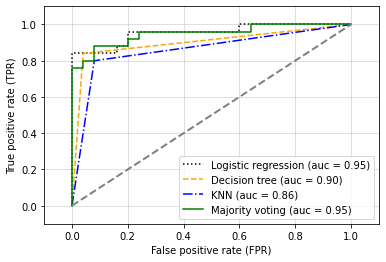

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # 양성 클래스의 레이블이 1이라고 가정합니다
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


# plt.savefig('images/07_04', dpi=300)
plt.show()

In [21]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

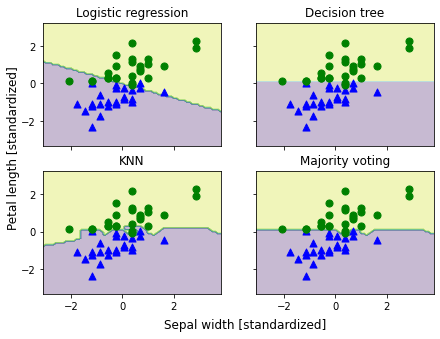

In [22]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

# plt.savefig('images/07_05', dpi=300)
plt.show()

In [23]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipe

In [24]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [25]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: 0.98


**노트**  
`GridSearchCV`의 `refit` 기본값은 `True`입니다(즉, `GridSeachCV(..., refit=True)`). 훈련된 `GridSearchCV` 추정기를 사용해 `predict` 메서드로 예측을 만들 수 있다는 뜻입니다. 예를 들면:

    grid = GridSearchCV(estimator=mv_clf, 
                        param_grid=params, 
                        cv=10, 
                        scoring='roc_auc')
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

또한 `best_estimator_` 속성으로 "최상"의 추정기를 얻을 수 있습니다.

In [26]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [27]:
mv_clf = grid.best_estimator_

In [28]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [29]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

사이킷런 0.22버전에서 `StackingClassifier`와 `StackingRegressor`가 추가되었습니다. 앞서 만든 분류기를 사용해 `StackingClassifier`에 그리드 서치를 적용해 보겠습니다. `StackingClassifier`는 `VotingClassifier`와 비슷하게 `estimators` 매개변수로 분류기 이름과 객체로 구성된 튜플의 리스트를 입력받습니다. `final_estimator` 매개변수로는 최종 결정을 위한 분류기를 지정합니다. 매개변수 그리드를 지정할 때는 튜플에 사용한 분류기 이름을 접두사로 사용합니다.

In [30]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
                           final_estimator=LogisticRegression())

params = {'dt__max_depth': [1, 2],
          'lr__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=stack,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.950 +/- 0.07 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 1, 'lr__clf__C': 100.0}
0.950 +/- 0.07 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [31]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'dt__max_depth': 1, 'lr__clf__C': 0.1}
정확도: 0.98


<br>
<br>

# 배깅: 부트스트랩 샘플링을 통한 분류 앙상블

In [32]:
Image(url='https://git.io/Jtsk4', width=500) 

## 배깅 알고리즘의 작동 방식

In [33]:
Image(url='https://git.io/JtskB', width=400) 

## 배깅으로 Wine 데이터셋의 샘플 분류

In [34]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# UCI 머신 러닝 저장소에서 Wine 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:

# df_wine = pd.read_csv('wine.data', header=None)

# 클래스 1 제외
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [36]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [37]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


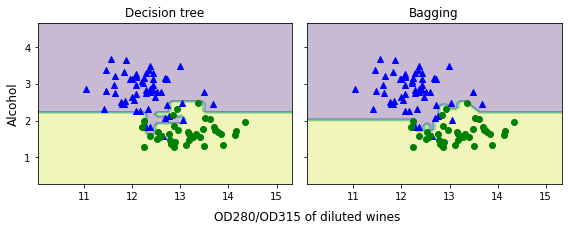

In [38]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

랜덤 포레스트와 배깅은 모두 기본적으로 부트스트랩 샘플링을 사용하기 때문에 분류기마다 훈련에 사용하지 않는 여분의 샘플이 남습니다. 이를 OOB(out of bag) 샘플이라고 합니다. 이를 사용하면 검증 세트를 만들지 않고 앙상블 모델을 평가할 수 있습니다. 사이킷런에서는 `oob_score` 매개변수를 `True`로 설정하면 됩니다. 이 매개변수의 기본값은 `False`입니다.
사이킷런의 랜덤 포레스트는 분류일 경우 OOB 샘플에 대한 각 트리의 예측 확률을 누적하여 가장 큰 확률을 가진 클래스를 타깃과 비교하여 정확도를 계산합니다. 회귀일 경우에는 각 트리의 예측 평균에 대한 R2 점수를 계산합니다. 이 점수는 `oob_score_` 속성에 저장되어 있습니다. `RandomForestClassifier`에 Wine 데이터셋을 적용하여 OOB 점수를 계산해 보겠습니다.

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True,
                            random_state=1)
rf.fit(X_train, y_train)

rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print('랜덤 포레스트의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (rf_train_score, rf_test_score))
print('랜덤 포레스트의 OOB 정확도 %.3f' % rf.oob_score_)

랜덤 포레스트의 훈련 정확도/테스트 정확도 1.000/0.917
랜덤 포레스트의 OOB 정확도 0.884


배깅의 OOB 점수 계산 방식은 랜덤 포레스트와 거의 동일합니다. 다만 `base_estimator`에 지정된 분류기가 `predict_proba` 메서드를 지원하지 않을 경우 예측 클래스를 카운팅하여 가장 높은 값의 클래스를 사용해 정확도를 계산합니다. 본문에서 만든 것과 동일한 `BaggingClassifier` 모델를 만들고 OOB 점수를 계산해 보겠습니다.

In [40]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        random_state=1)
bag.fit(X_train, y_train)

bag_train_score = bag.score(X_train, y_train)
bag_test_score = bag.score(X_test, y_test)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (bag_train_score, bag_test_score))
print('배깅의 OOB 정확도 %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도 1.000/0.917
배깅의 OOB 정확도 0.895


<br>
<br>

# 약한 학습기를 이용한 에이다부스트

## 부스팅 작동 원리

In [41]:
Image(url='https://git.io/Jtsk0', width=400) 

In [42]:
Image(url='https://git.io/Jtskg', width=500) 

## 사이킷런에서 에이다부스트 사용

In [43]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [44]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875
에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.917


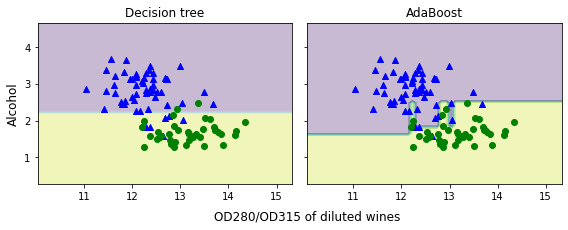

In [45]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

그레이디언트 부스팅은 에이다부스트와는 달리 이전의 약한 학습기가 만든 잔차 오차(residual error)에 대해 학습하는 새로운 학습기를 추가합니다. 신경망 알고리즘이 잘 맞는 이미지, 텍스트 같은 데이터를 제외하고 구조적인 데이터셋에서 현재 가장 높은 성능을 내는 알고리즘 중 하나입니다. 사이킷런에는 `GradientBoostingClassifier`와 `GradientBoostingRegressor` 클래스로 구현되어 있습니다. 앞에서 사용한 훈련 데이터를 이용하여 그레이디언트 부스팅 모델을 훈련시켜 보죠.

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)
gbrt.fit(X_train, y_train)

gbrt_train_score = gbrt.score(X_train, y_train)
gbrt_test_score = gbrt.score(X_test, y_test)
print('그래디언트 부스팅의 훈련 정확도/테스트 정확도 %.3f/%.3f' 
      % (gbrt_train_score, gbrt_test_score))

그래디언트 부스팅의 훈련 정확도/테스트 정확도 1.000/0.917


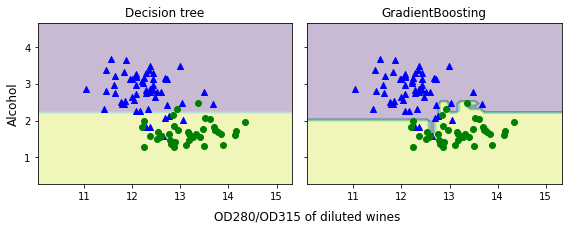

In [47]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, gbrt],
                        ['Decision tree', 'GradientBoosting']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('images/07_gradientboosting.png', dpi=300, bbox_inches='tight')
plt.show()

그레이디언트 부스팅에서 중요한 매개변수 중 하나는 각 트리가 오차에 기여하는 정도를 조절하는 `learning_rate`입니다. `learning_rate`이 작으면 성능은 높아지지만 많은 트리가 필요합니다. 이 매개변수의 기본값은 0.1입니다.

그레이디언트 부스팅이 사용하는 손실 함수는 `loss` 매개변수에서 지정합니다. `GradientBoostingClassifier`일 경우 로지스틱 회귀를 의미하는 `'deviance'`, `GradientBoostingRegressor`일 경우 최소 제곱을 의미하는 `'ls'`가 기본값입니다.

그레이디언트 부스팅이 오차를 학습하기 위해 사용하는 학습기는 `DecisionTreeRegressor`입니다. `DecisionTreeRegressor`의 불순도 조건은 `'mse'`, `'mae'` 등 입니다. 따라서 그레이디언트 부스팅의 `criterion` 매개변수도 `DecisionTreeRegressor`의 불순도 조건을 따라서 `'mse'`, `'mae'`, 그리고 제롬 H. 프리드먼(Jerome H. Friedman)이 제안한 MSE 버전인 `'friedman_mse'`(기본값)를 사용합니다. 하지만 `'mae'`일 경우 그레이디언트 부스팅의 결과가 좋지 않기 때문에 이 옵션은 사이킷런 0.24버전부터 경고가 발생하고 0.26버전에서 삭제될 예정입니다.

`subsample` 매개변수를 기본값 1.0 보다 작은 값으로 지정하면 훈련 데이터셋에서 `subsample` 매개변수에 지정된 비율만큼 랜덤하게 샘플링하여 트리를 훈련합니다. 이를 확률적 그레이디언트 부스팅이라고 부릅니다. 이는 랜덤 포레스트나 에이다부스트의 부트스트랩 샘플링과 비슷하게 과대적합을 줄이는 효과를 냅니다. 또한 남은 샘플을 사용해 OOB 점수를 계산할 수 있습니다. `subsample` 매개변수가 1.0보다 작을 때 그레이디언트 부스팅 객체의 `oob_improvement_` 속성에 이전 트리의 OOB 손실 값에서 현재 트리의 OOB 손실을 뺀 값이 기록되어 있습니다. 이 값에 음수를 취해서 누적하면 트리가 추가되면서 과대적합되는 지점을 찾을 수 있습니다.

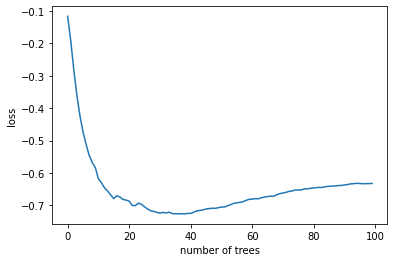

In [48]:
gbrt = GradientBoostingClassifier(n_estimators=100, 
                                  subsample=0.5,
                                  random_state=1)
gbrt.fit(X_train, y_train)
oob_loss = np.cumsum(-gbrt.oob_improvement_)
plt.plot(range(100), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')

# plt.savefig('images/07_oob_improvement.png', dpi=300)
plt.show()

사이킷런 0.20 버전부터는 그레이디언트 부스팅에 조기 종료(early stopping) 기능을 지원하기 위한 매개변수 `n_iter_no_change`, `validation_fraction`, `tol`이 추가되었습니다. 훈련 데이터에서 `validation_fraction` 비율(기본값 0.1)만큼 떼어 내어 측정한 손실이 `n_iter_no_change` 반복 동안에 `tol` 값(기본값 1e-4) 이상 향상되지 않으면 훈련이 멈춥니다.

히스토그램 기반 부스팅은 입력 특성을 256개의 구간으로 나누어 노드를 분할에 사용합니다. 일반적으로 샘플 개수가 10,000개보다 많은 경우 그레이디언트 부스팅보다 히스토그램 기반 부스팅이 훨씬 빠릅니다. 앞에서와 같은 데이터를 히스토그램 기반 부스팅 구현인 `HistGradientBoostingClassifier`에 적용해 보겠습니다. 이 클래스는 아직 실험적이기 때문에 사용하기 전에 먼저 활성화 해야 합니다.

In [49]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
 
hgbc = HistGradientBoostingClassifier(random_state=1)
hgbc.fit(X_train, y_train)

hgbc_train_score = gbrt.score(X_train, y_train)
hgbc_test_score = gbrt.score(X_test, y_test)
print('그래디언트 부스팅 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (hgbc_train_score, hgbc_test_score))

그래디언트 부스팅 훈련 정확도/테스트 정확도 1.000/0.917


사이킷런 0.24버전부터 `HistGradientBoostingClassifier`와 `HistGradientBoostingRegressor`에서 범주형 특성을 그대로 사용할 수 있습니다. `categorical_features` 매개변수에 불리언 배열이나 정수 인덱스 배열을 전달하여 범주형 특성을 알려주어야 합니다.

XGBoost(https://xgboost.ai/)에서도 `tree_method` 매개변수를 `'hist'`로 지정하여 히스토그램 기반 부스팅을 사용할 수 있습니다. 코랩에는 이미 XGBoost 라이브러리가 설치되어 있으므로 간단히 테스트해 볼 수 있습니다.

In [50]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=1)
xgb.fit(X_train, y_train)

xgb_train_score = xgb.score(X_train, y_train)
xgb_test_score = xgb.score(X_test, y_test)

print('XGBoost 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (xgb_train_score, xgb_test_score))

XGBoost 훈련 정확도/테스트 정확도 0.968/0.917


또 다른 인기 높은 히스토그램 기반 부스팅 알고리즘은 마이크로소프트에서 만든 LightGBM(https://lightgbm.readthedocs.io/)입니다. 사실 사이킷런의 히스토그램 기반 부스팅은 LightGBM에서 영향을 많이 받았습니다. LightGBM도 코랩에서 바로 테스트해 볼 수 있습니다.

In [51]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=1)
lgb.fit(X_train, y_train)

lgb_train_score = lgb.score(X_train, y_train)
lgb_test_score = lgb.score(X_test, y_test)

print('LightGBM 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (lgb_train_score, lgb_test_score))

LightGBM 훈련 정확도/테스트 정확도 0.968/0.917


<br>
<br>